# Librairies

In [1]:
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as random
from jax import jit
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.decomposition import PCA, KernelPCA
import time
from IPython.display import clear_output, display

import flax
import optax
import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.tools import sinkhorn_divergence
from ott.tools import plot

import ot
import ot as pot

import torchdyn
from torchdyn.core import NeuralODE

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *
from torchcfm.optimal_transport import OTPlanSampler

from src.icnn import ICNN, sampler_from_data
from src.ot_solver import OT_Solver
from src.sinkhorn_loss import sinkhorn_loss
from src.plotdataset import plot_dataset
from src.mini_batch_ot import mini_batch, update_plan, compute_incomplete_plan

# Import Amazon and caltech images

In [2]:
class ToBlackAndWhite(object):
    def __call__(self, img):
        return img.convert('L')
    
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

caltech_db = torchvision.datasets.ImageFolder(root='C:\\Users\\yanis\\OneDrive\\Documents\\ENSAE 3A\\OT\\projet\\images\\caltech10', transform=transform)
print(caltech_db.class_to_idx)
amazon_db = torchvision.datasets.ImageFolder(root='C:\\Users\\yanis\\OneDrive\\Documents\\ENSAE 3A\\OT\\projet\\images\\amazon', transform=transform)
print(amazon_db.class_to_idx)

{'backpack': 0, 'bike': 1, 'calculator': 2, 'headphones': 3, 'keyboard': 4, 'laptop': 5, 'monitor': 6, 'mouse': 7, 'mug': 8, 'projector': 9}
{'backpack': 0, 'bike': 1, 'calculator': 2, 'headphones': 3, 'keyboard': 4, 'laptop': 5, 'monitor': 6, 'mouse': 7, 'mug': 8, 'projector': 9}


In [3]:
caltech_dataloader = DataLoader(caltech_db, batch_size=1123, shuffle=True)
amazon_dataloader = DataLoader(amazon_db, batch_size=919, shuffle=True)

img_tensor_caltech, label_tensor_caltech = next(iter(caltech_dataloader))
img_tensor_amazon, label_tensor_amazon = next(iter(amazon_dataloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


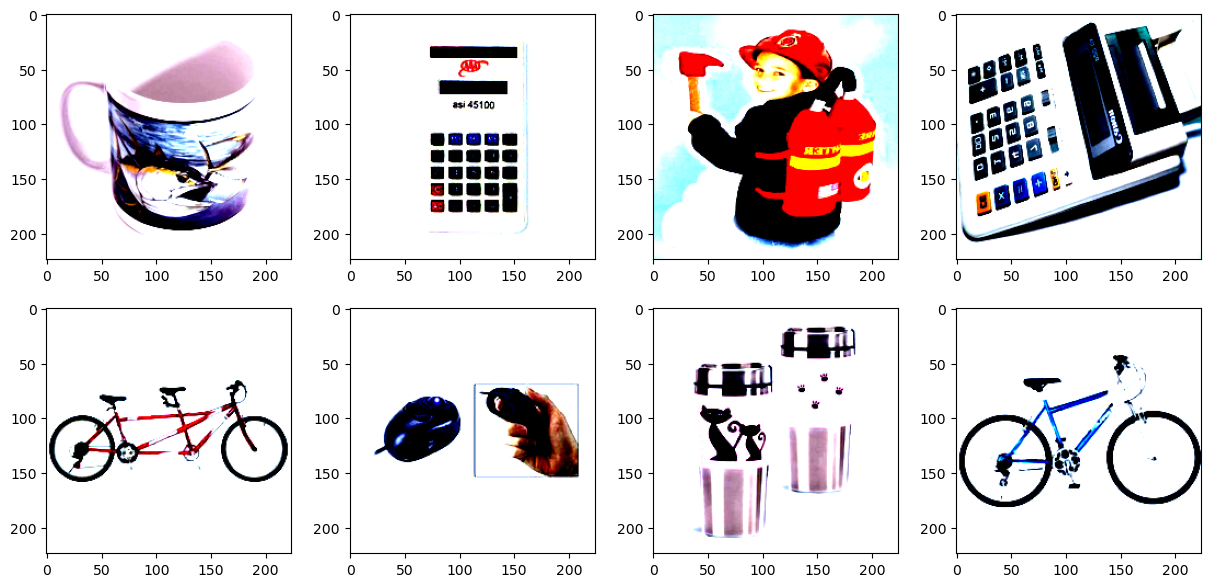

In [7]:
fig, axs = plt.subplots(2, 4, figsize=(15, 7))

axs[0,0].imshow(img_tensor_caltech.permute(0, 2, 3, 1)[0].numpy())
axs[0,1].imshow(img_tensor_caltech.permute(0, 2, 3, 1)[1].numpy())
axs[0,2].imshow(img_tensor_caltech.permute(0, 2, 3, 1)[2].numpy())
axs[0,3].imshow(img_tensor_caltech.permute(0, 2, 3, 1)[3].numpy())


axs[1,0].imshow(img_tensor_amazon.permute(0, 2, 3, 1)[0].numpy())
axs[1,1].imshow(img_tensor_amazon.permute(0, 2, 3, 1)[1].numpy())
axs[1,2].imshow(img_tensor_amazon.permute(0, 2, 3, 1)[2].numpy())
axs[1,3].imshow(img_tensor_amazon.permute(0, 2, 3, 1)[3].numpy())

plt.show()

# Preprocessing

## Flatten transformation

In [4]:
flatten_tensor_caltech = torch.flatten(img_tensor_caltech, start_dim = 1)
flatten_tensor_amazon = torch.flatten(img_tensor_amazon, start_dim = 1)

print(flatten_tensor_caltech.shape)

array_flatten_caltech = flatten_tensor_caltech.numpy()
array_flatten_amazon = flatten_tensor_amazon.numpy()

label_caltech = label_tensor_caltech.numpy()
label_amazon = label_tensor_amazon.numpy()

torch.Size([1123, 150528])


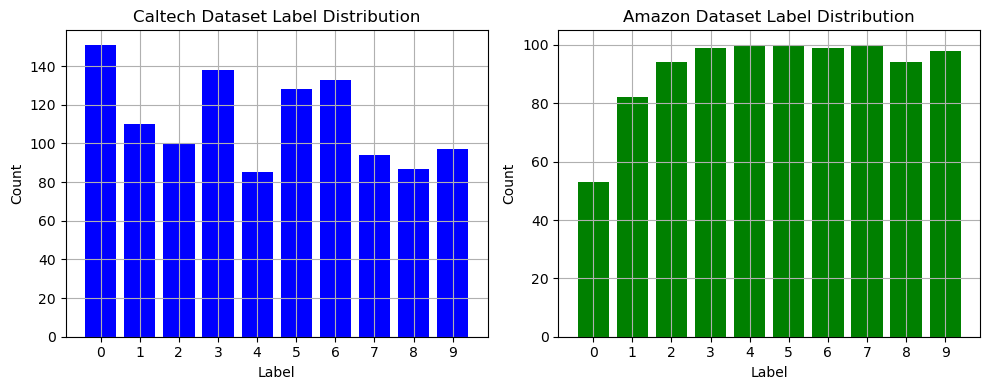

In [5]:
caltech_label_counts = np.bincount(label_caltech)
caltech_num_classes = len(caltech_label_counts)

amazon_label_counts = np.bincount(label_amazon)
amazon_num_classes = len(amazon_label_counts)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.bar(range(caltech_num_classes), caltech_label_counts, color='blue')
plt.title('Caltech Dataset Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(range(caltech_num_classes))
plt.grid(True)

plt.subplot(1, 2, 2)
plt.bar(range(amazon_num_classes), amazon_label_counts, color='green')
plt.title('Amazon Dataset Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(range(amazon_num_classes))
plt.grid(True)

plt.tight_layout()
plt.show()

## Kernel PCA

In [5]:
kpca_dims = KernelPCA(kernel='poly')
kpca_dims.fit(array_flatten_caltech)
kpca_transform = kpca_dims.transform(array_flatten_caltech)
explained_variance = np.var(kpca_transform, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
cumsum = np.cumsum(explained_variance_ratio)
d = np.argmax(cumsum >= 0.95) + 1
print("Number of components to explain 95% percent of variance: {}".format(d))

Number of components to explain 95% percent of variance: 686


In [6]:
kpca = KernelPCA(n_components = d)
kpca.fit(array_flatten_caltech)

array_flatten_caltech_reduced = kpca.transform(array_flatten_caltech)
array_flatten_amazon_reduced = kpca.transform(array_flatten_amazon)
print("reduced shape: " + str(array_flatten_caltech_reduced.shape))

reduced shape: (1123, 686)


In [7]:
X = jnp.array(array_flatten_caltech_reduced) #X: caltech (source distribution)
Y = jnp.array(array_flatten_amazon_reduced)  #Y: amazon (target distribution)

# Label annotation

## Entropic Map

In [10]:
reg_list = [1, 10, 100]

for i, reg in enumerate(reg_list):
    print("Entropic OT plan (reg:{})".format(reg))
    geom = ott.geometry.pointcloud.PointCloud(X, Y, epsilon = reg)    # Define an euclidean geometry
    problem = ott.problems.linear.linear_problem.LinearProblem(geom)  # Define your problem
    solver = ott.solvers.linear.sinkhorn.Sinkhorn()                   # Select the Sinkhorn solver

    out = solver(problem)                                             # Solve it !

    f = out.f                                                         # Get back the potentials f and g
    g = out.g

    # Define entropic map with the output of the solver
    entropic_map = out.to_dual_potentials()
    # Transport X with this map
    transported_samples_entropic = entropic_map.transport(X)
    # Compute Sinkhorn distance
    sinkhorn_div_entropic = sinkhorn_loss(transported_samples_entropic, Y)
    print(f"Sinkhorn distance - Entropic Map (reg={reg}): {sinkhorn_div_entropic:.2f}")
    # Compute overall distance
    dist_entropic = entropic_map.distance(X, Y)
    print(f"Entropic dual distance (reg={reg}): {dist_entropic:.2f}")
    
    clf = SVC()
    clf.fit(transported_samples_entropic, label_caltech)
    label_amazon_pred= clf.predict(array_flatten_amazon_reduced)
    print("Accuracy - reg = {}: {}".format(reg, accuracy_score(label_amazon, label_amazon_pred)))
    print("Balanced accuracy - reg = {}: {}\n".format(reg, balanced_accuracy_score(label_amazon, label_amazon_pred)))

Entropic OT plan (reg:1)
Sinkhorn distance - Entropic Map (reg=1): 32751.70
Entropic dual distance (reg=1): 222221.41
Accuracy - reg = 1: 0.3808487486398259
Balanced accuracy - reg = 1: 0.40201206807161205

Entropic OT plan (reg:10)
Sinkhorn distance - Entropic Map (reg=10): 20597.88
Entropic dual distance (reg=10): 258099.95
Accuracy - reg = 10: 0.36126224156692055
Balanced accuracy - reg = 10: 0.38118640406820575

Entropic OT plan (reg:100)
Sinkhorn distance - Entropic Map (reg=100): 7652.72
Entropic dual distance (reg=100): 351472.50
Accuracy - reg = 100: 0.33623503808487487
Balanced accuracy - reg = 100: 0.36157474578916643



## ICNN

In [8]:
sampler_source_train = sampler_from_data(X)
sampler_target_train = sampler_from_data(Y)

In [9]:
%%time
icnn = ICNN(dim_hidden=[128,128,128,128])
optimizer = optax.adam(learning_rate=1e-3)

# Set input dimensions
input_dim = 686
# Set the number of steps
num_train_iters = 10000
batch_size = 64

# Setup the solver
solver = OT_Solver(
    input_dim = input_dim,
    neural_net = icnn,
    optimizer = optimizer,
    num_train_iters = num_train_iters
)

# Launch the train !
OT_state = solver(
    sampler_source = sampler_source_train,
    sampler_target = sampler_target_train,
    size_batch_train = batch_size
)

loss After 0 Iterations : 254299.312500
loss After 100 Iterations : 147868.343750
loss After 200 Iterations : 127953.992188
loss After 300 Iterations : 127126.187500
loss After 400 Iterations : 125439.367188
loss After 500 Iterations : 111612.734375
loss After 600 Iterations : 121416.406250
loss After 700 Iterations : 103433.312500
loss After 800 Iterations : 115346.687500
loss After 900 Iterations : 130071.250000
loss After 1000 Iterations : 125643.453125
loss After 1100 Iterations : 129093.851562
loss After 1200 Iterations : 104922.570312
loss After 1300 Iterations : 106206.468750
loss After 1400 Iterations : 108309.937500
loss After 1500 Iterations : 125642.257812
loss After 1600 Iterations : 121660.359375
loss After 1700 Iterations : 119665.000000
loss After 1800 Iterations : 126690.531250
loss After 1900 Iterations : 121139.421875
loss After 2000 Iterations : 110100.296875
loss After 2100 Iterations : 109632.507812
loss After 2200 Iterations : 109517.765625
loss After 2300 Iterati

In [10]:
predict = OT_state.apply_fn
params = OT_state.params

# Extract the ot map from predict
ot_map_point = jax.grad(predict, argnums=1)

# Use vmap to vectorize the ot_map
ot_map = jax.vmap(lambda x: ot_map_point({'params': params}, x))

# Get the prediction
transported_samples_icnn = ot_map(X)

In [11]:
sinkhorn_div_icnn = sinkhorn_loss(transported_samples_icnn, Y)
print(f"Sinkhorn distance - (ICNN): {sinkhorn_div_icnn:.2f}")

Sinkhorn distance - (ICNN): 95481.72


In [52]:
clf = SVC()
clf.fit(transported_samples_icnn, label_caltech)
label_amazon_pred= clf.predict(array_flatten_amazon_reduced)

print("Accuracy: {}".format(accuracy_score(label_amazon, label_amazon_pred)))
print("Balanced accuracy: {}".format(balanced_accuracy_score(label_amazon, label_amazon_pred)))

Accuracy: 0.2611534276387378
Balanced accuracy: 0.29116863830897766


# Conditional Flow Matching

In [53]:
X_tensor = torch.tensor(array_flatten_caltech_reduced, dtype = torch.float32)
Y_tensor = torch.tensor(array_flatten_amazon_reduced, dtype= torch.float32)

In [55]:
%%time
sigma = 0.1
dim = X_tensor.shape[1]
model = MLP(dim = dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
FM = ConditionalFlowMatcher(sigma=sigma)
n_epochs = 10000
batch_size = 64
min_samples_x_y = np.min((X_tensor.shape[0], Y_tensor.shape[0]))

for k in range(n_epochs):
    num_batch_img = 0
    while num_batch_img < min_samples_x_y:
        random_ind_x = torch.randperm(X_tensor.size(0))[:batch_size]
        random_ind_y = torch.randperm(Y_tensor.size(0))[:batch_size]

        optimizer.zero_grad()
        t, xt, ut = FM.sample_location_and_conditional_flow(X_tensor[random_ind_x], Y_tensor[random_ind_y])
        vt = model(torch.cat([xt, t[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()
        num_batch_img+=batch_size
        
    if (k + 1) % 1000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f}")
        start = end
        node = NeuralODE(torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
        with torch.no_grad():
            traj = node.trajectory(
                X_tensor,
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())

clear_output()

CPU times: total: 40min 14s
Wall time: 8min 57s


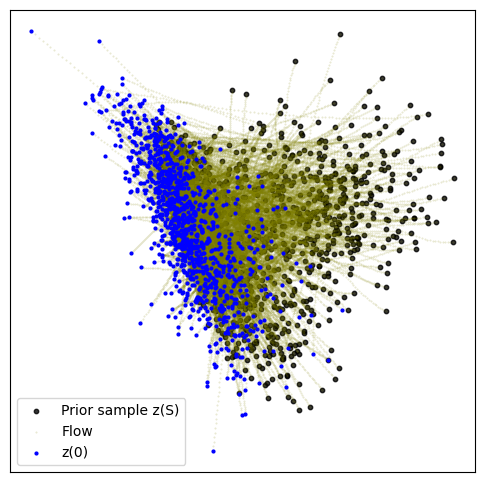

Sinkhorn distance between target predictions and data samples: 179937.83


In [56]:
transported_samples_conditionnal_flow = node.trajectory(x=X_tensor, t_span=torch.linspace(0, 1, 100))

## Plot OT map
plot_trajectories(transported_samples_conditionnal_flow.detach().numpy())
## Compute Sinkhorn distance
sinkhorn_div_conditional_flow = sinkhorn_loss(jnp.array(transported_samples_conditionnal_flow[-1].detach().numpy()), Y)
print(f"Sinkhorn distance between target predictions and data samples: {sinkhorn_div_conditional_flow:.2f}")

In [57]:
clf = SVC()
clf.fit(transported_samples_conditionnal_flow[-1].detach().numpy(), label_caltech)
label_amazon_pred= clf.predict(array_flatten_amazon_reduced)

print("Accuracy: {}".format(accuracy_score(label_amazon, label_amazon_pred)))
print("Balanced accuracy: {}".format(balanced_accuracy_score(label_amazon, label_amazon_pred)))

Accuracy: 0.06964091403699674
Balanced accuracy: 0.06931647002500402


# Mini-batch OT

In [58]:
# We pre-compute the ground cost matrix
M = torch.cdist(X_tensor, Y_tensor) ** 2

ot_plan_list = []
num_iter = 10000
a, b = ot.unif(X_tensor.shape[0]), ot.unif(Y_tensor.shape[0])

ot_sampler = OTPlanSampler(method="exact")
pi = ot_sampler.get_map(X_tensor, Y_tensor)
ot_plan_list.append(pi)

# Compuete incomplete mbot plan for several batch sizes
batch_size_list = [128, 64]

for i, batch_size in enumerate(batch_size_list):
    incomplete_mbot_plan = compute_incomplete_plan(X_tensor, Y_tensor, a, b, batch_size, num_iter, M.numpy())
    ot_plan_list.append(incomplete_mbot_plan)

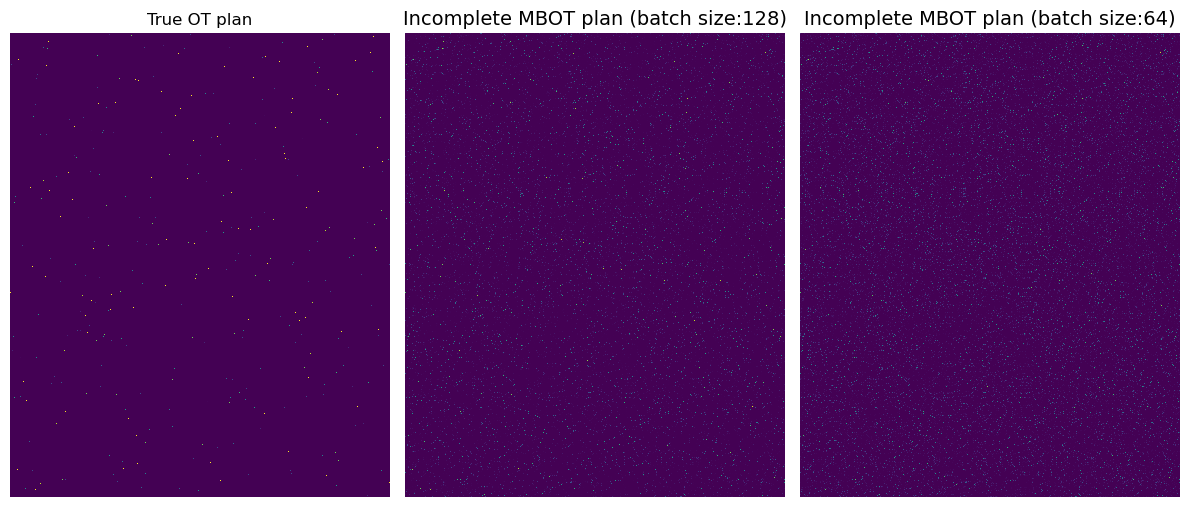

In [59]:
plt.figure(figsize=(12, 5))

ax1 = plt.subplot(1, 3, 1)
ax1.imshow(ot_plan_list[0], interpolation="nearest")
ax1.axis("off")
ax1.set_title("True OT plan")

for i in range(2):
    ax = plt.subplot(1, 3, i + 2)
    ax.imshow(ot_plan_list[i + 1], interpolation="nearest")
    ax.axis("off")
    batch_size = batch_size_list[i]
    ax.set_title("Incomplete MBOT plan (batch size:{})".format(batch_size), fontsize=14)

plt.tight_layout()
plt.show()

10000: loss 175.204
Sinkhorn distance - OT-CFM trained with true OT plan: 134199.31
10000: loss 253.341
Sinkhorn distance - OT-CFM trained w. MBOT (size:128): 156641.42


<timed exec>:68: UserWarning: The figure layout has changed to tight


10000: loss 272.355
Sinkhorn distance - OT-CFM trained w. MBOT (size:128): 162872.45
CPU times: total: 51min 11s
Wall time: 11min 1s


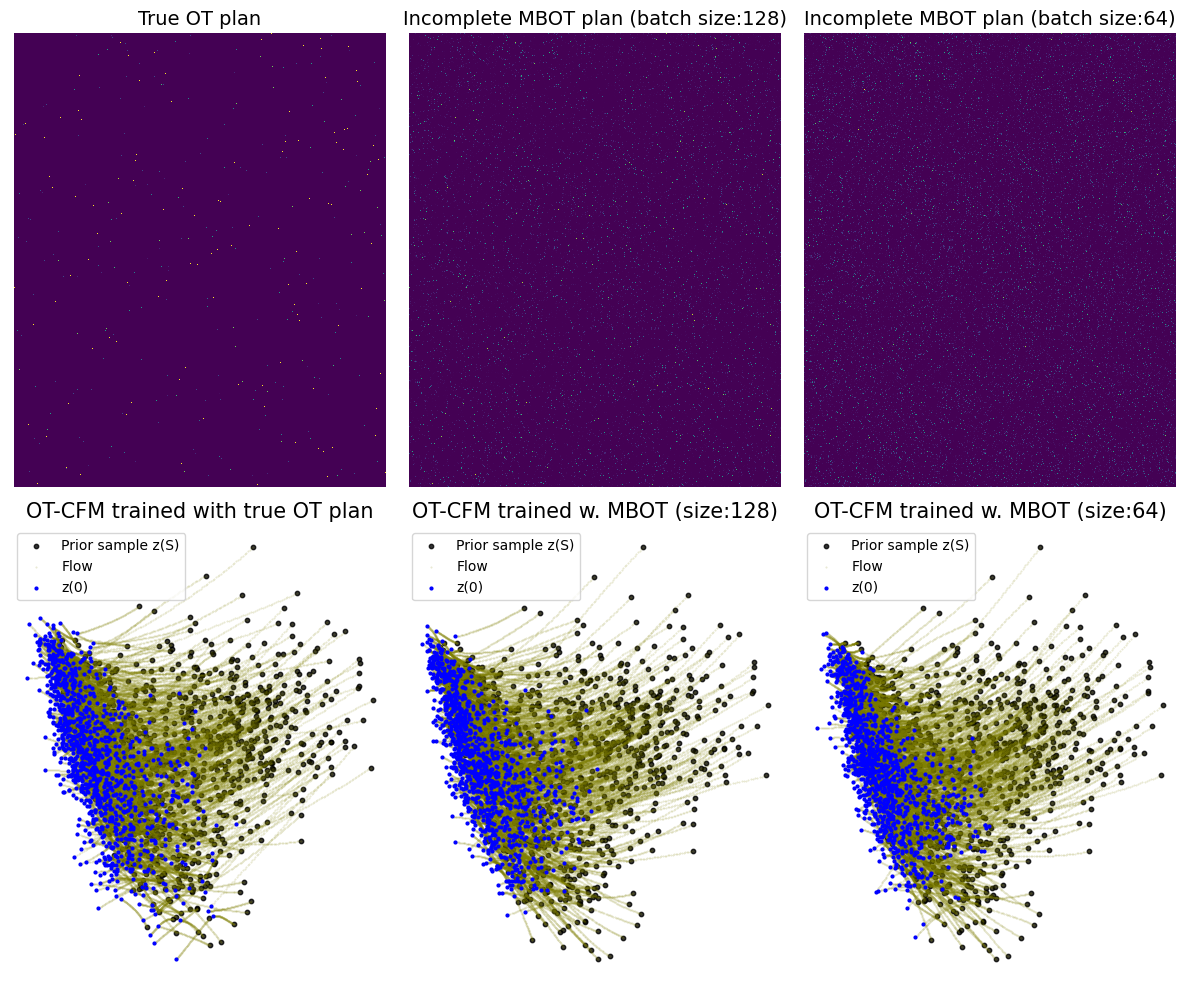

In [60]:
%%time
sigma = 0.1
dim = X_tensor.shape[1]
plt.figure(3, figsize=(12, 10))
batch_size = 128
n_epochs = 10000

list_transported_samples_minibatch_ot = []

for i, mbot_plan in enumerate(ot_plan_list):
    model = MLP(dim = dim, time_varying=True)
    optimizer = torch.optim.Adam(model.parameters())
    FM = ConditionalFlowMatcher(sigma=sigma)

    ot_sampler = OTPlanSampler(method="exact")

    for k in range(n_epochs):
        optimizer.zero_grad()

        indices_i, indices_j = ot_sampler.sample_map(mbot_plan, batch_size=batch_size, replace=False)
        batch_x0, batch_x1 = X_tensor[indices_i], Y_tensor[indices_j]
        t, xt, ut = FM.sample_location_and_conditional_flow(batch_x0, batch_x1)
        vt = model(torch.cat([xt, t[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()

    print(f"{k+1}: loss {loss.item():0.3f}")
    node = NeuralODE(torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
    with torch.no_grad():
        traj = node.trajectory(
            X_tensor,
            t_span=torch.linspace(0, 1, 100),
        )
        
        sinkhorn_div = sinkhorn_loss(jnp.array(traj[-1].detach().numpy()), Y)
        if i == 0:
          print(f"Sinkhorn distance - OT-CFM trained with true OT plan: {sinkhorn_div:.2f}")
        else:
          print(f"Sinkhorn distance - OT-CFM trained w. MBOT (size:{batch_size}): {sinkhorn_div:.2f}")
          
        plt.subplot(2, 3, i + 1)
        plt.imshow(ot_plan_list[i], interpolation="nearest")
        plt.axis("off")
        if i == 0:
            plt.title("True OT plan", fontsize=14)
        else:
            batch_size = batch_size_list[i - 1]
            plt.title("Incomplete MBOT plan (batch size:{})".format(batch_size), fontsize=14)

        plt.subplot(2, 3, i + 4)
        traj = traj.cpu().numpy()
        list_transported_samples_minibatch_ot.append(traj[-1])
        plt.scatter(
            traj[0, :X_tensor.shape[0], 0], traj[0, :X_tensor.shape[0], 1], s=10, alpha=0.8, c="black"
        )
        plt.scatter(
            traj[:, :X_tensor.shape[0], 0], traj[:, :X_tensor.shape[0], 1], s=0.2, alpha=0.2, c="olive"
        )
        plt.scatter(traj[-1, :X_tensor.shape[0], 0], traj[-1, :X_tensor.shape[0], 1], s=4, alpha=1, c="blue")
        plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
        plt.xticks([])
        plt.yticks([])
        plt.axis("off")
        if i == 0:
            plt.title("OT-CFM trained with true OT plan", fontsize=15)
        else:
            plt.title("OT-CFM trained w. MBOT (size:{})".format(batch_size), fontsize=15)
        plt.tight_layout()

In [61]:
for i, transported_samples in enumerate(list_transported_samples_minibatch_ot):
    clf = SVC()
    clf.fit(transported_samples, label_caltech)
    label_amazon_pred = clf.predict(array_flatten_amazon_reduced)

    if i == 0:
        print("Accuracy: {} - OT-CFM trained with true OT plan".format(accuracy_score(label_amazon, label_amazon_pred)))
        print("Balanced accuracy: {} - OT-CFM trained with true OT plan".format(balanced_accuracy_score(label_amazon, label_amazon_pred)))
    
    elif i == 1:
        print("Accuracy: {} - OT-CFM trained w. MBOT (size:64)".format(accuracy_score(label_amazon, label_amazon_pred)))
        print("Balanced accuracy: {} - OT-CFM trained w. MBOT (size:64)".format(balanced_accuracy_score(label_amazon, label_amazon_pred)))
    else:
        print("Accuracy: {} - OT-CFM trained w. MBOT (size:128)".format(accuracy_score(label_amazon, label_amazon_pred)))
        print("Balanced accuracy: {} - OT-CFM trained w. MBOT (size:128)".format(balanced_accuracy_score(label_amazon, label_amazon_pred)))

Accuracy: 0.3177366702937976 - OT-CFM trained with true OT plan
Balanced accuracy: 0.3438957933382517 - OT-CFM trained with true OT plan
Accuracy: 0.3177366702937976 - OT-CFM trained w. MBOT (size:64)
Balanced accuracy: 0.34668561099639533 - OT-CFM trained w. MBOT (size:64)
Accuracy: 0.2807399347116431 - OT-CFM trained w. MBOT (size:128)
Balanced accuracy: 0.3107135402155817 - OT-CFM trained w. MBOT (size:128)


# SB-CFM: OT-CFM trained with Entropic OT

c:\Users\yanis\anaconda3\Lib\site-packages\ot\bregman\_sinkhorn.py:498: RuntimeWarning: divide by zero encountered in divide
  v = b / KtransposeU
c:\Users\yanis\anaconda3\Lib\site-packages\ot\bregman\_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
c:\Users\yanis\anaconda3\Lib\site-packages\torchcfm\optimal_transport.py:92: UserWarning: Numerical errors in OT plan, reverting to uniform plan.
  warnings.warn("Numerical errors in OT plan, reverting to uniform plan.")


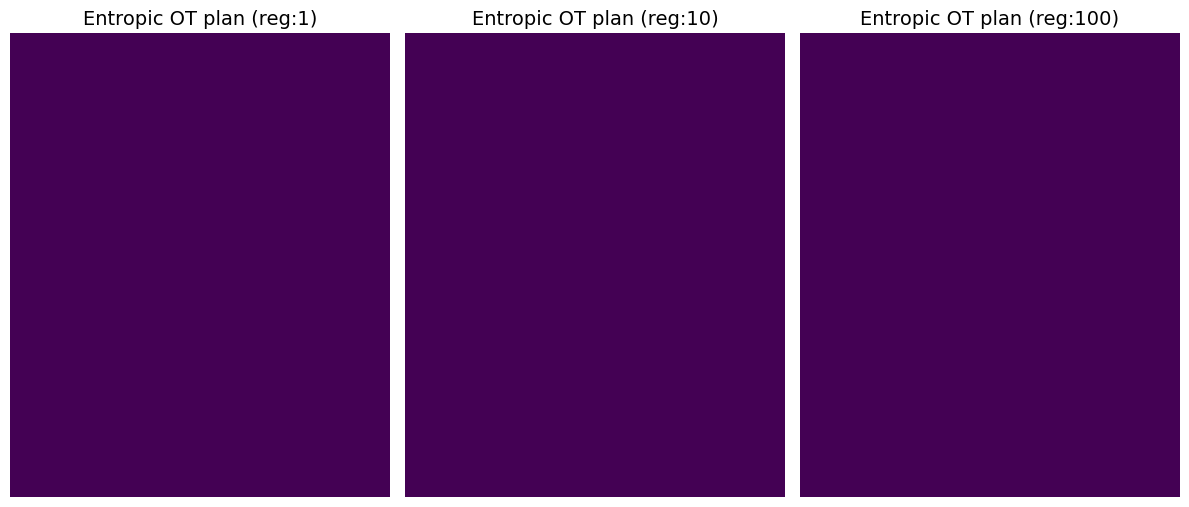

In [62]:
reg_list = [1, 10, 100]

plt.figure(figsize=(12, 5))
ot_plan_list = []

for i, reg in enumerate(reg_list):
    ot_sampler = OTPlanSampler(method="sinkhorn", reg=reg)
    entropic_ot_plan = ot_sampler.get_map(X_tensor, Y_tensor)
    ot_plan_list.append(entropic_ot_plan)

for i, reg in enumerate(reg_list):
    plt.subplot(1, 3, i + 1)
    plt.imshow(ot_plan_list[i], interpolation="nearest")
    plt.axis("off")
    plt.title("Entropic OT plan (reg:{})".format(reg), fontsize=14)

plt.tight_layout()
plt.show()


10000: loss 376.342
Sinkhorn distance - Entropic-OT plan (reg=1): 189082.16
10000: loss 389.066
Sinkhorn distance - Entropic-OT plan (reg=10): 186559.94


<timed exec>:64: UserWarning: The figure layout has changed to tight


10000: loss 366.899
Sinkhorn distance - Entropic-OT plan (reg=100): 179134.16
CPU times: total: 43min 53s
Wall time: 9min 52s


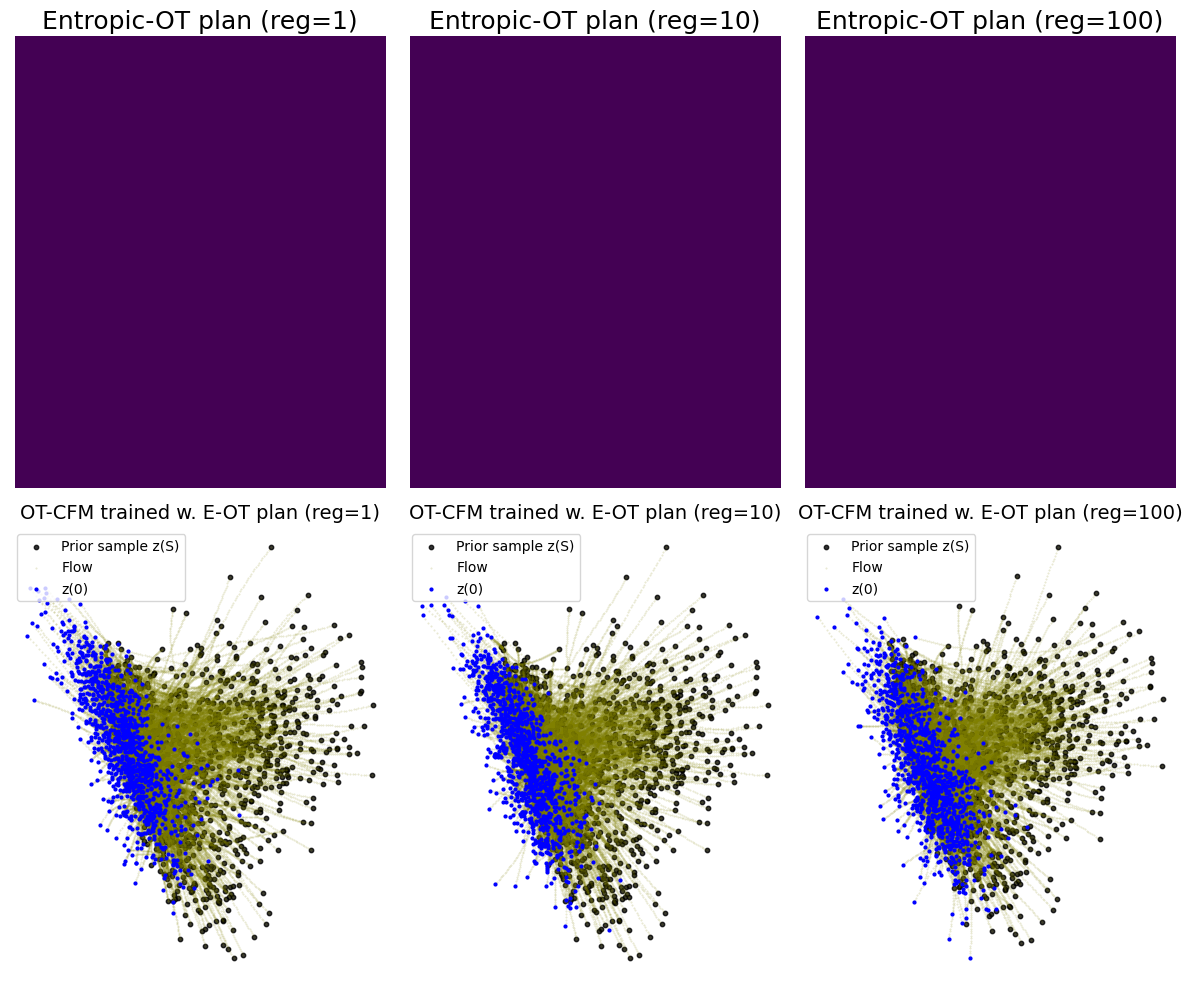

In [63]:
%%time
sigma = 0.1
dim = X_tensor.shape[1]
batch_size = 128
list_transported_samples_sbcfm = []

plt.figure(3, figsize=(12, 10))

for i, reg in enumerate(reg_list):
    model = MLP(dim=dim, time_varying=True)
    optimizer = torch.optim.Adam(model.parameters())
    FM = ConditionalFlowMatcher(sigma=sigma)

    ot_sampler = OTPlanSampler(method="sinkhorn", reg=reg)

    pi = ot_sampler.get_map(X_tensor, Y_tensor)

    for k in range(n_epochs):
        optimizer.zero_grad()

        indices_i, indices_j = ot_sampler.sample_map(pi, batch_size=batch_size, replace=False)
        batch_x0, batch_x1 = X_tensor[indices_i], Y_tensor[indices_j]

        t, xt, ut = FM.sample_location_and_conditional_flow(batch_x0, batch_x1)

        vt = model(torch.cat([xt, t[:, None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)

        loss.backward()
        optimizer.step()

    print(f"{k+1}: loss {loss.item():0.3f}")
    start = end
    node = NeuralODE(torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
    )
    with torch.no_grad():
        traj = node.trajectory(
            X_tensor,
            t_span=torch.linspace(0, 1, 100),
        )

        sinkhorn_div = sinkhorn_loss(jnp.array(traj[-1].detach().numpy()), Y)
        print(f"Sinkhorn distance - Entropic-OT plan (reg={reg}): {sinkhorn_div:.2f}")

        plt.subplot(2, 3, i + 1)
        plt.imshow(ot_plan_list[i], interpolation="nearest")
        plt.axis("off")
        plt.title("Entropic-OT plan (reg={})".format(reg), fontsize=18)

        plt.subplot(2, 3, i + 4)
        traj = traj.cpu().numpy()
        list_transported_samples_sbcfm.append(traj[-1])
        plt.scatter(
            traj[0, :X.shape[0], 0], traj[0, :X.shape[0], 1], s=10, alpha=0.8, c="black"
        )
        plt.scatter(
            traj[:, :X.shape[0], 0], traj[:, :X.shape[0], 1], s=0.2, alpha=0.2, c="olive"
        )
        plt.scatter(traj[-1, :X.shape[0], 0], traj[-1, :X.shape[0], 1], s=4, alpha=1, c="blue")
        plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
        plt.xticks([])
        plt.yticks([])
        plt.axis("off")
        plt.title("OT-CFM trained w. E-OT plan (reg={})".format(reg), fontsize=14)
        plt.tight_layout()

In [65]:
for i, transported_samples in enumerate(list_transported_samples_sbcfm):
    clf = SVC()
    clf.fit(transported_samples, label_caltech)
    label_amazon_pred = clf.predict(array_flatten_amazon_reduced)

    if i == 0:
        print("Accuracy: {} - OT-CFM trained w. E-OT plan (reg=1)".format(accuracy_score(label_amazon, label_amazon_pred)))
        print("Balanced accuracy: {} - OT-CFM trained w. E-OT plan (reg=1)".format(balanced_accuracy_score(label_amazon, label_amazon_pred)))
    
    elif i == 1:
        print("Accuracy: {} - OT-CFM trained w. E-OT plan (reg=10)".format(accuracy_score(label_amazon, label_amazon_pred)))
        print("Balanced accuracy: {} - OT-CFM trained w. E-OT plan (reg=10)".format(balanced_accuracy_score(label_amazon, label_amazon_pred)))
    else:
        print("Accuracy: {} - OT-CFM trained w. E-OT plan (reg=100)".format(accuracy_score(label_amazon, label_amazon_pred)))
        print("Balanced accuracy: {} - OT-CFM trained w. E-OT plan (reg=100)".format(balanced_accuracy_score(label_amazon, label_amazon_pred)))

Accuracy: 0.17301414581066377 - OT-CFM trained w. E-OT plan (reg=1)
Balanced accuracy: 0.1815360445488782 - OT-CFM trained w. E-OT plan (reg=1)
Accuracy: 0.15669205658324264 - OT-CFM trained w. E-OT plan (reg=10)
Balanced accuracy: 0.1472152589056943 - OT-CFM trained w. E-OT plan (reg=10)
Accuracy: 0.12622415669205658 - OT-CFM trained w. E-OT plan (reg=100)
Balanced accuracy: 0.12991870775114006 - OT-CFM trained w. E-OT plan (reg=100)
